<>:126: SyntaxWarning: invalid escape sequence '\h'
<>:147: SyntaxWarning: invalid escape sequence '\h'
<>:126: SyntaxWarning: invalid escape sequence '\h'
<>:147: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-1776960439.py:126: SyntaxWarning: invalid escape sequence '\h'
  ax.plot(t, xhat_hist[0], label='Estimated $\hat{x}_1(k)$', color=color_est, alpha=0.95, linewidth=2.0)
/tmp/ipython-input-1776960439.py:147: SyntaxWarning: invalid escape sequence '\h'
  ax.plot(t, xhat_hist[1], label='Estimated $\hat{x}_2(k)$', color=color_est, alpha=0.95, linewidth=2.0)
/tmp/ipython-input-1776960439.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_hist[0] = float(H @ x_true + np.random.randn()*np.sqrt(R))
/tmp/ipython-input-1776960439.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to 

Saved: ./aesthetic_short_x1_post.png


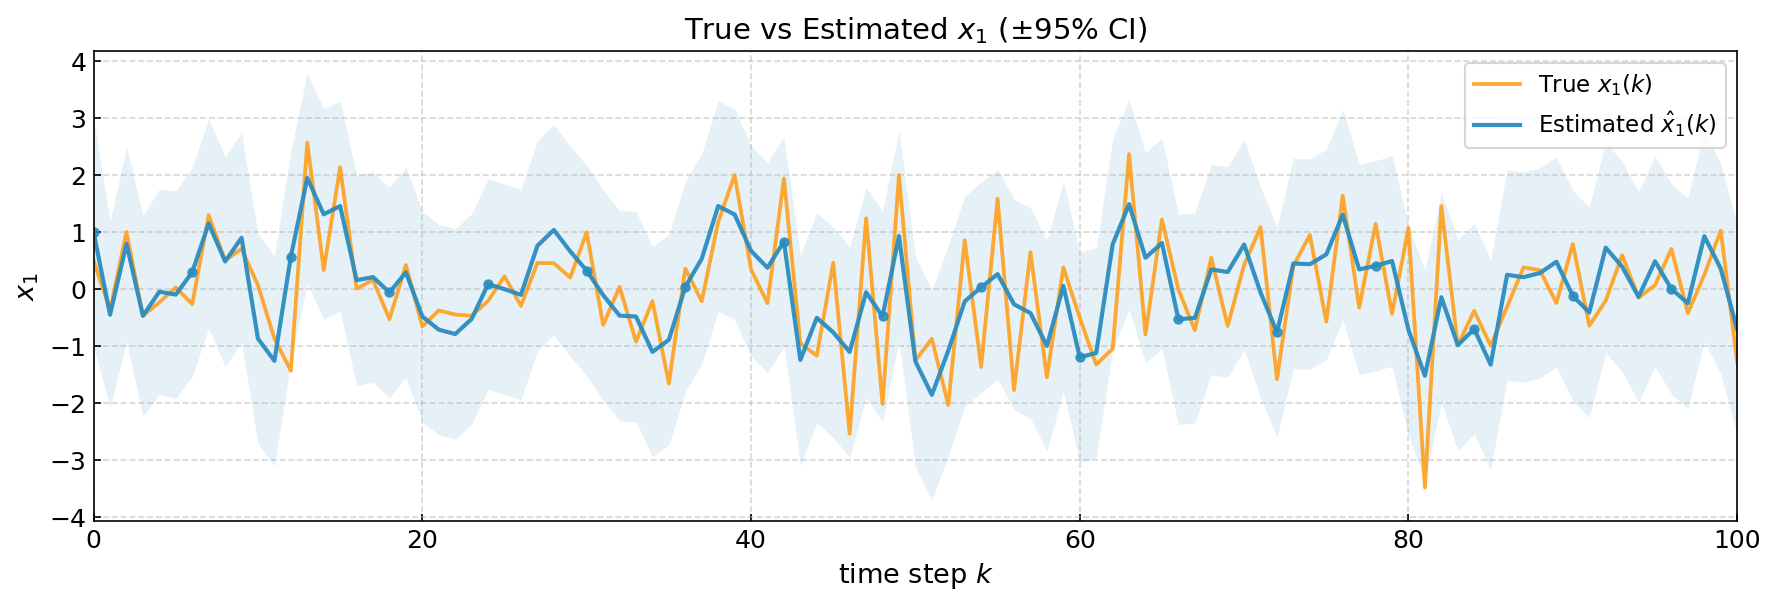

Saved: ./aesthetic_short_x2_post.png


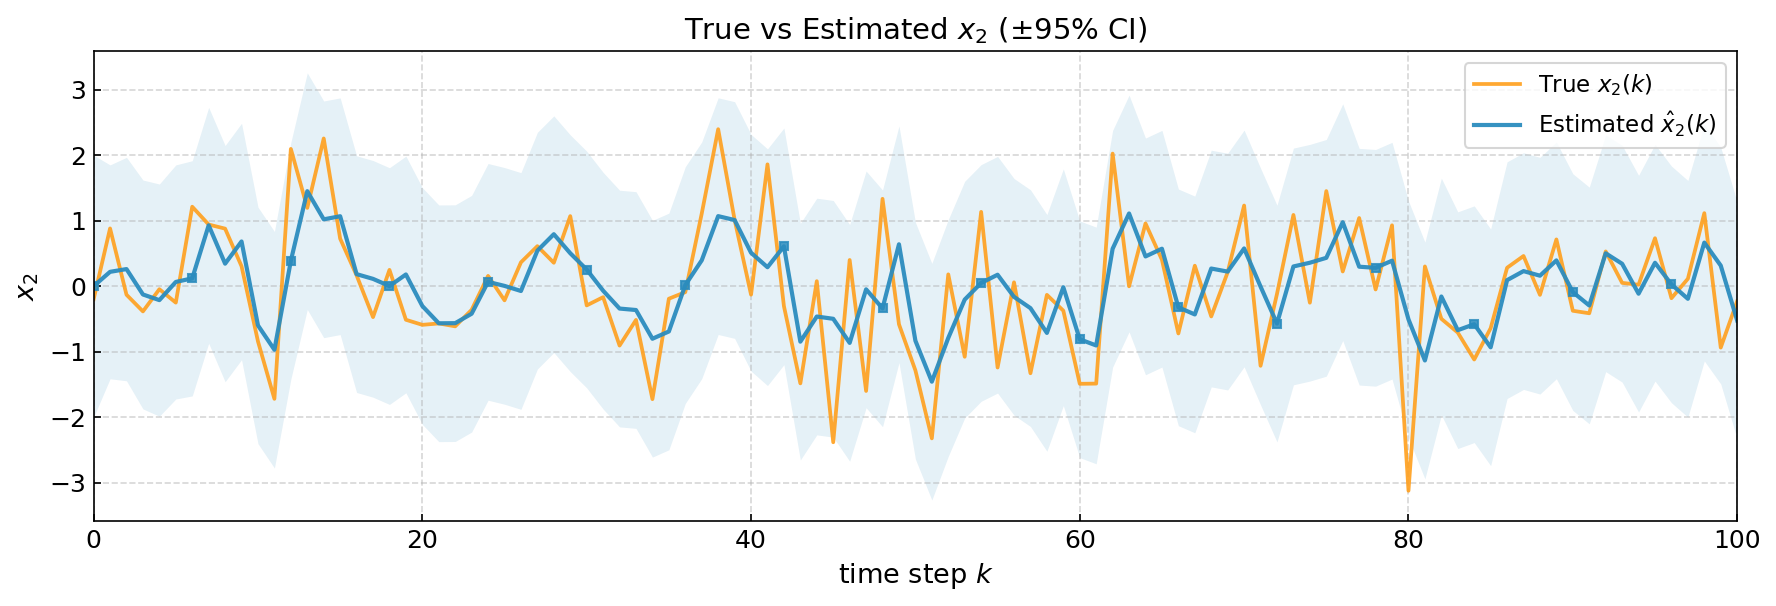

Saved: ./aesthetic_short_y_post.png


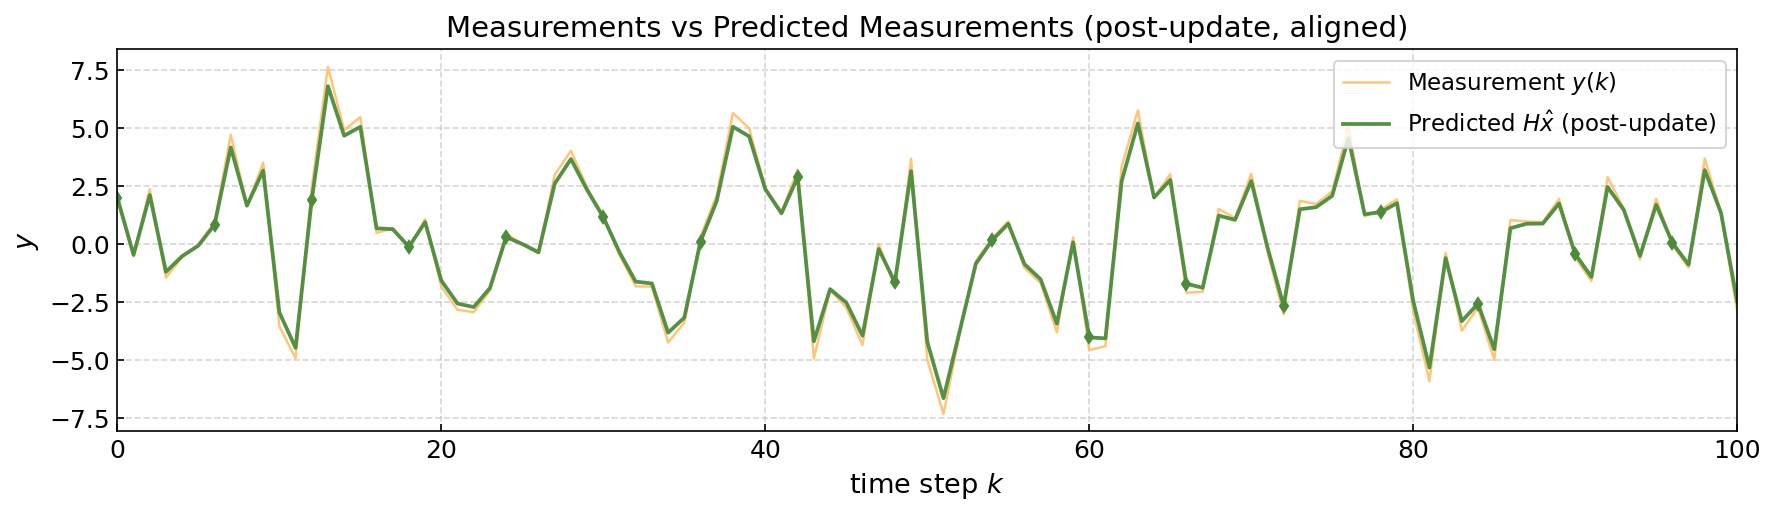

Simulation finished. N = 100
Final estimate xhat(N|N) = [-0.70584309 -0.52489369]
Final covariance P(N|N) =
 [[ 0.85251527 -0.72453158]
 [-0.72453158  0.8163006 ]]
Uploaded screenshot (local): /mnt/data/Screenshot 2025-11-23 112546.png


In [1]:
"""
Short-run Kalman Filter implementation
System:
    x(k+1) = A x(k) + B w(k)
    y(k)   = H x(k) + v(k)
"""

import numpy as np
import matplotlib.pyplot as plt
import os
def run_short_kf_aesthetic(seed=10, N=100, save_plots=True, out_dir='.'):
    np.random.seed(seed)
#given system data
    A = np.array([[-1/3, 1.0],
                  [ 1/3, 0.0]])
    B = np.array([[0.0],
                  [1.0]])
    H = np.array([[2.0, 2.0]])

    # Noise variances that we are using (standard normla)
    Q_w = 1.0
    R = 1.0

    # Process noise covariance
    Qx = B @ (Q_w * np.eye(1)) @ B.T      # = [[0,0],[0,1]]

    # Initial givenfilter estimate & covariance
    xhat = np.array([[1.0],
                     [0.0]])              # xhat(0|0)
    P = np.eye(2)                         # P(0|0)

    # True initial state for simulation (unchanged)
    x_true = np.array([[0.5],
                       [-0.2]])

    # Storage arrays
    x_true_hist = np.zeros((2, N+1))
    xhat_hist = np.zeros((2, N+1))
    Pdiag_hist = np.zeros((2, N+1))
    y_hist = np.zeros(N+1)

    # store prior and posterior predicted measurement
    y_prior_hist = np.zeros(N+1)   # H @ xhat_pred (a-priori)
    y_post_hist  = np.zeros(N+1)   # H @ xhat (a-posteriori, aligned with y)

    # initialize storage at k=0
    x_true_hist[:, 0] = x_true.flatten()
    xhat_hist[:, 0] = xhat.flatten()
    Pdiag_hist[:, 0] = np.diag(P)

    y_hist[0] = float(H @ x_true + np.random.randn()*np.sqrt(R))
    # initial predictions
    y_prior_hist[0] = float(H @ xhat)   # prior equals posterior at time 0 here
    y_post_hist[0]  = float(H @ xhat)

    # Kalman filter loop for k = 0..N-1 producing states at k+1
    for k in range(N):
        #truth propagation (simulate system)
        w_k = np.random.randn() * np.sqrt(Q_w)
        x_true = A @ x_true + B * w_k            # 2x1

        # measurement at time k+1
        v_k = np.random.randn() * np.sqrt(R)
        y_k1 = float(H @ x_true) + v_k

        #predict (a-priori for time k+1)
        xhat_pred = A @ xhat
        P_pred = A @ P @ A.T + Qx

        #store prior predicted measurement for diagnostic (H * xhat_pred)
        y_prior = float(H @ xhat_pred)
        idx = k + 1
        y_prior_hist[idx] = y_prior

        # update using measurement y_k1 (becomes xhat at time k+1)
        S = float(H @ P_pred @ H.T) + R
        K = (P_pred @ H.T) / S
        innov = y_k1 - y_prior                    # innovation uses prior
        xhat = xhat_pred + K * innov
        P = (np.eye(2) - K @ H) @ P_pred

        #  store posterior / bookkeeping
        x_true_hist[:, idx] = x_true.flatten()
        xhat_hist[:, idx] = xhat.flatten()
        Pdiag_hist[:, idx] = np.diag(P)
        y_hist[idx] = y_k1
        y_post_hist[idx] = float(H @ xhat)


    t = np.arange(N+1)
  #plots
    plt.rcParams.update({
        'figure.dpi': 150,
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 13,
        'legend.fontsize': 11,
        'lines.linewidth': 1.6,
        'axes.grid': True,
        'grid.linestyle': '--',
        'grid.alpha': 0.5
    })

    color_true = '#ff9f1c'
    color_est  = '#2b8cbe'
    ci_color    = '#2b8cbe'
    meas_color  = '#ffbf69'
    pred_color  = '#4b8b3b'

    mark_every = 6
    os.makedirs(out_dir, exist_ok=True)

    # Plot x1
    fig, ax = plt.subplots(figsize=(12, 4.2))
    ax.plot(t, x_true_hist[0], label='True $x_1(k)$', color=color_true, alpha=0.9, linewidth=1.8)
    ax.plot(t, xhat_hist[0], label='Estimated $\hat{x}_1(k)$', color=color_est, alpha=0.95, linewidth=2.0)
    ax.plot(t[::mark_every], xhat_hist[0, ::mark_every], marker='o', linestyle='',
            color=color_est, markersize=4, alpha=0.85)
    std1 = np.sqrt(Pdiag_hist[0])
    ax.fill_between(t, xhat_hist[0]-2*std1, xhat_hist[0]+2*std1, color=ci_color, alpha=0.12, linewidth=0)
    ax.set_xlabel('time step $k$')
    ax.set_ylabel('$x_1$')
    ax.set_title('True vs Estimated $x_1$ (±95% CI)')
    ax.legend(loc='upper right', frameon=True)
    ax.set_xlim(0, N)
    ax.tick_params(direction='in')
    fig.tight_layout()
    if save_plots:
        f = os.path.join(out_dir, 'aesthetic_short_x1_post.png')
        fig.savefig(f, dpi=300)
        print("Saved:", f)
    plt.show()

    # Plot x2
    fig, ax = plt.subplots(figsize=(12, 4.2))
    ax.plot(t, x_true_hist[1], label='True $x_2(k)$', color=color_true, alpha=0.9, linewidth=1.8)
    ax.plot(t, xhat_hist[1], label='Estimated $\hat{x}_2(k)$', color=color_est, alpha=0.95, linewidth=2.0)
    ax.plot(t[::mark_every], xhat_hist[1, ::mark_every], marker='s', linestyle='',
            color=color_est, markersize=4, alpha=0.85)
    std2 = np.sqrt(Pdiag_hist[1])
    ax.fill_between(t, xhat_hist[1]-2*std2, xhat_hist[1]+2*std2, color=ci_color, alpha=0.12, linewidth=0)
    ax.set_xlabel('time step $k$')
    ax.set_ylabel('$x_2$')
    ax.set_title('True vs Estimated $x_2$ (±95% CI)')
    ax.legend(loc='upper right', frameon=True)
    ax.set_xlim(0, N)
    ax.tick_params(direction='in')
    fig.tight_layout()
    if save_plots:
        f = os.path.join(out_dir, 'aesthetic_short_x2_post.png')
        fig.savefig(f, dpi=300)
        print("Saved:", f)
    plt.show()

    # Measurement vs **POSTERIOR** predicted measurement
    fig, ax = plt.subplots(figsize=(12, 3.6))
    ax.plot(t, y_hist, label='Measurement $y(k)$', color=meas_color, alpha=0.9, linewidth=1.2)
    ax.plot(t, y_post_hist, label='Predicted $H\\hat{x}$ (post-update)', color=pred_color, alpha=0.95, linewidth=1.8)
    ax.plot(t[::mark_every], y_post_hist[::mark_every], marker='d', linestyle='', color=pred_color, markersize=4)
    ax.set_xlabel('time step $k$')
    ax.set_ylabel('$y$')
    ax.set_title('Measurements vs Predicted Measurements (post-update, aligned)')
    ax.legend(loc='upper right', frameon=True)
    ax.set_xlim(0, N)
    ax.tick_params(direction='in')
    fig.tight_layout()
    if save_plots:
        f = os.path.join(out_dir, 'aesthetic_short_y_post.png')
        fig.savefig(f, dpi=300)
        print("Saved:", f)
    plt.show()

    # Summary
    print("Simulation finished. N =", N)
    print("Final estimate xhat(N|N) =", xhat.flatten())
    print("Final covariance P(N|N) =\n", P)
    print("Uploaded screenshot (local):", screenshot_path)

    return {
        't': t,
        'x_true': x_true_hist,
        'xhat': xhat_hist,
        'Pdiag': Pdiag_hist,
        'y': y_hist,
        'y_prior': y_prior_hist,
        'y_post': y_post_hist,
        'A': A, 'Qx': Qx, 'R': R,
        'screenshot': screenshot_path
    }

if __name__ == '__main__':
    # Run with N = 100 (as requested)
    results = run_short_kf_aesthetic(seed=10, N=100, save_plots=True, out_dir='.')


Saved: /mnt/data/long_improved_raw_x1_post.png


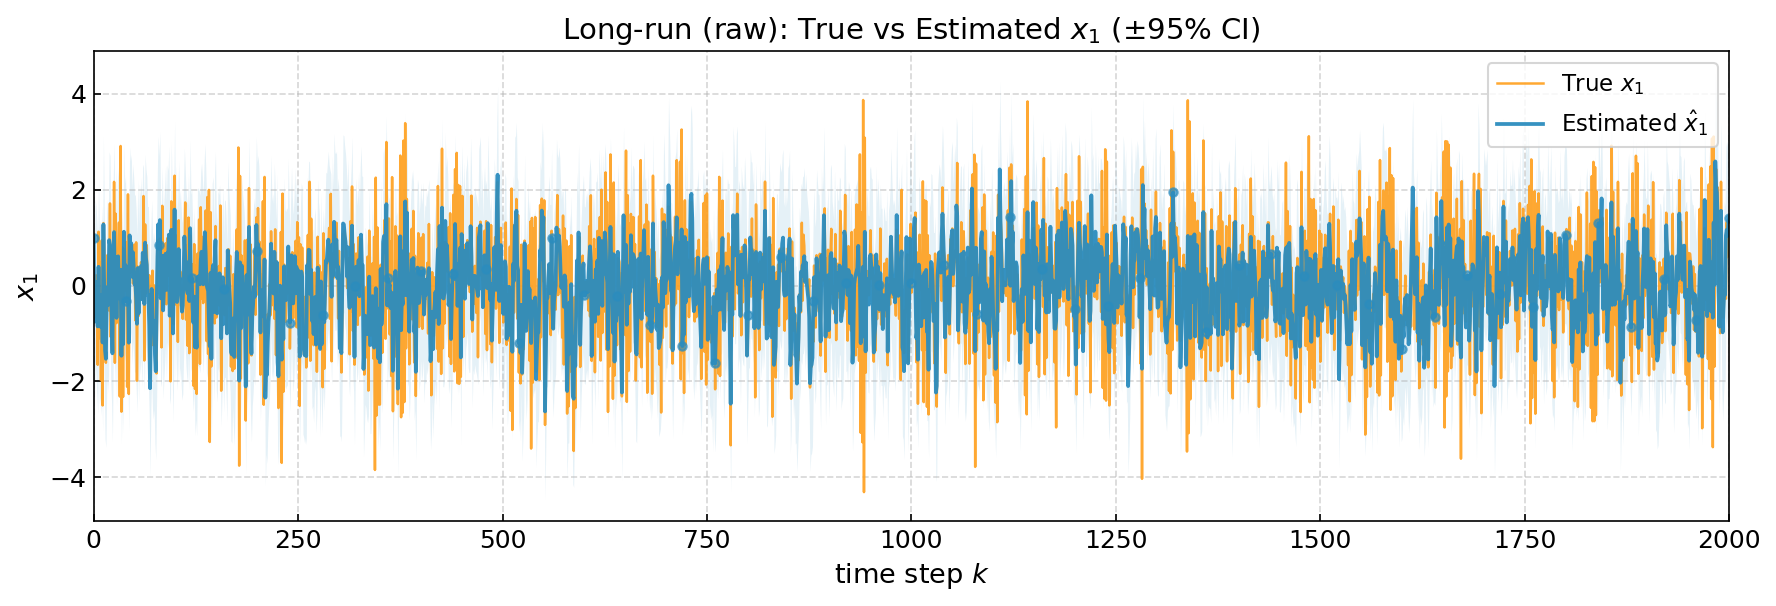

Saved: /mnt/data/long_improved_raw_x2_post.png


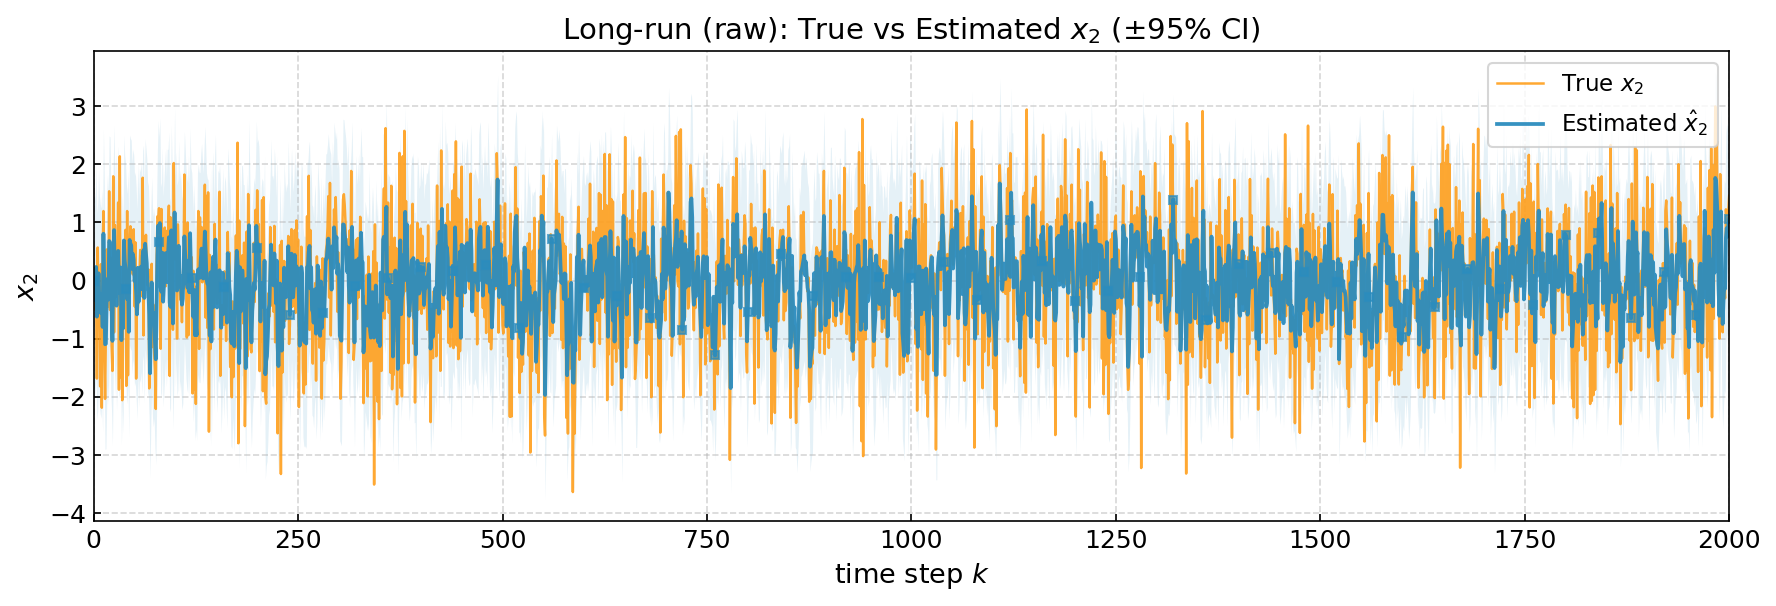

Saved: /mnt/data/long_improved_raw_y_post.png


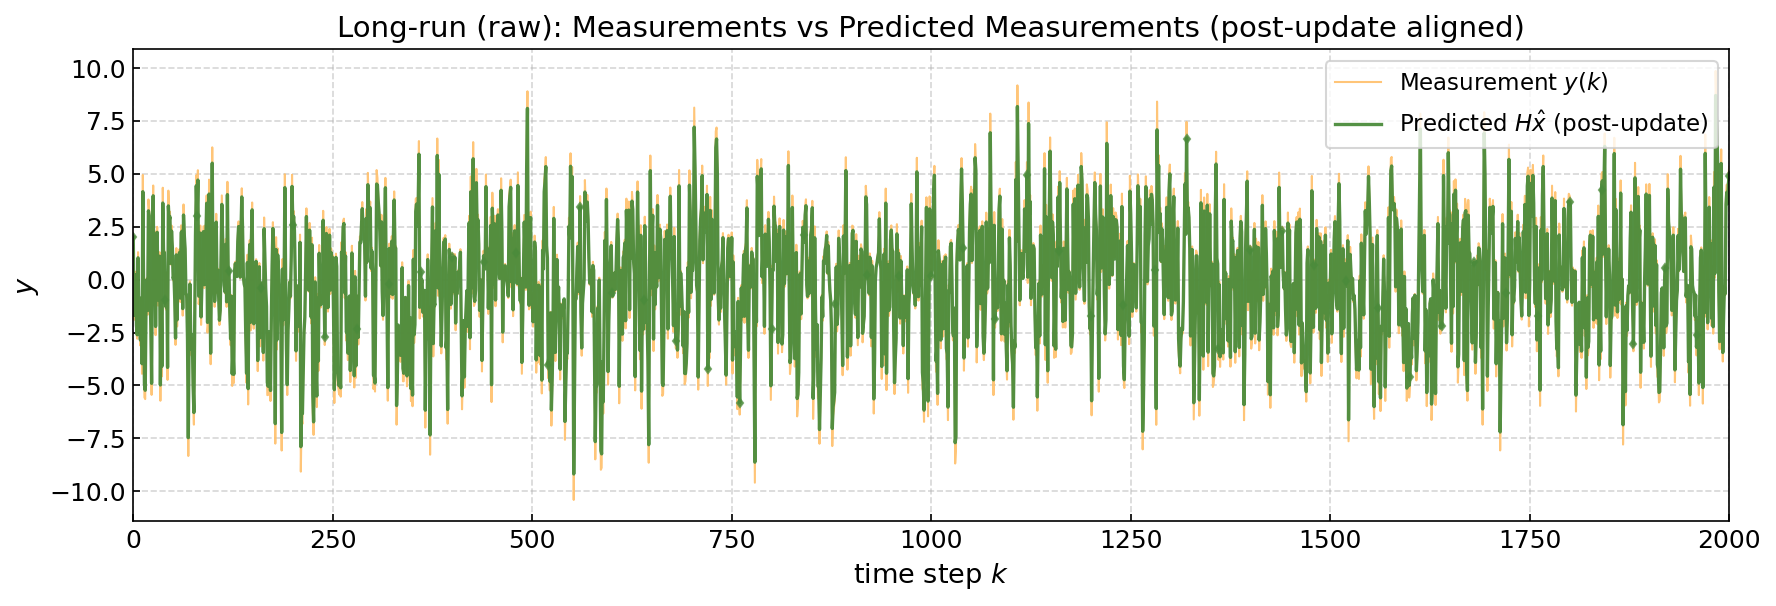

Saved: /mnt/data/long_improved_processed_x1_post.png


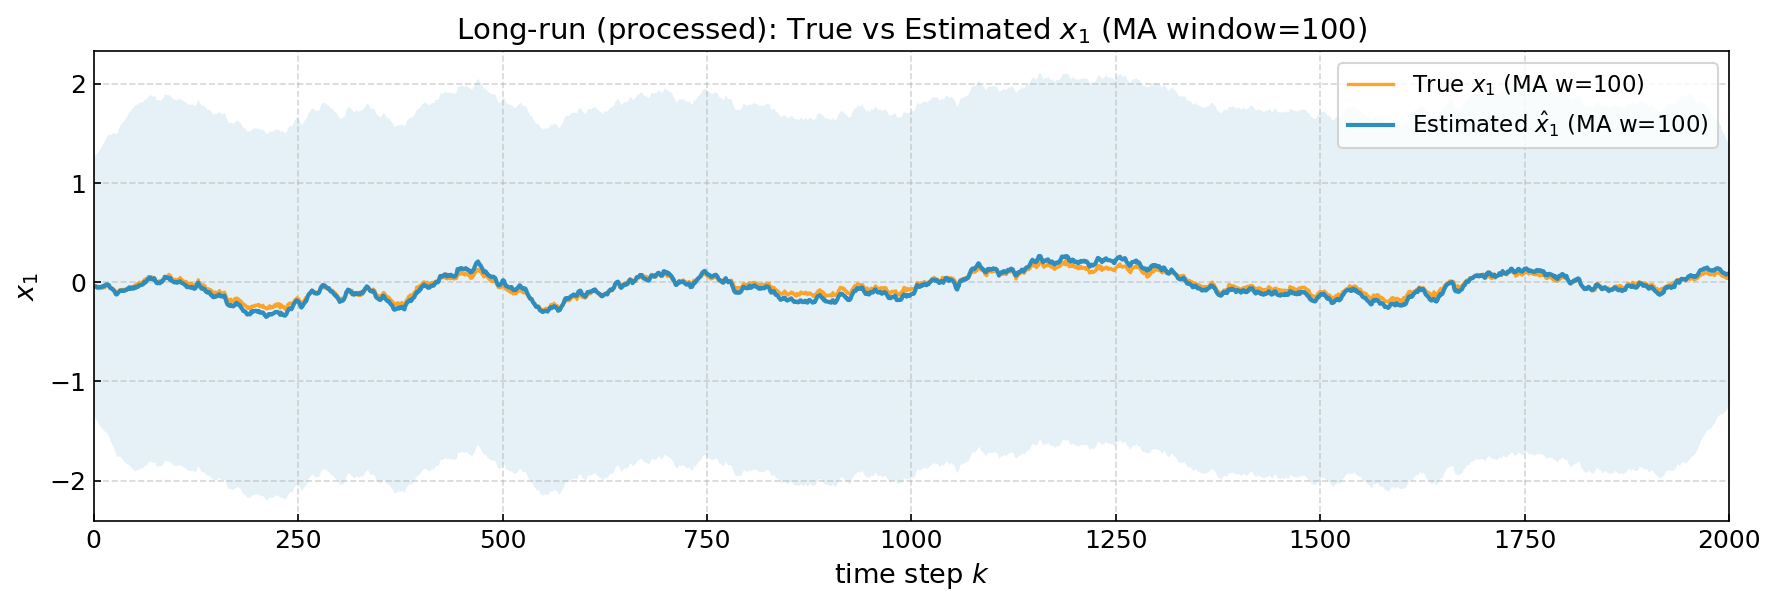

Saved: /mnt/data/long_improved_processed_x2_post.png


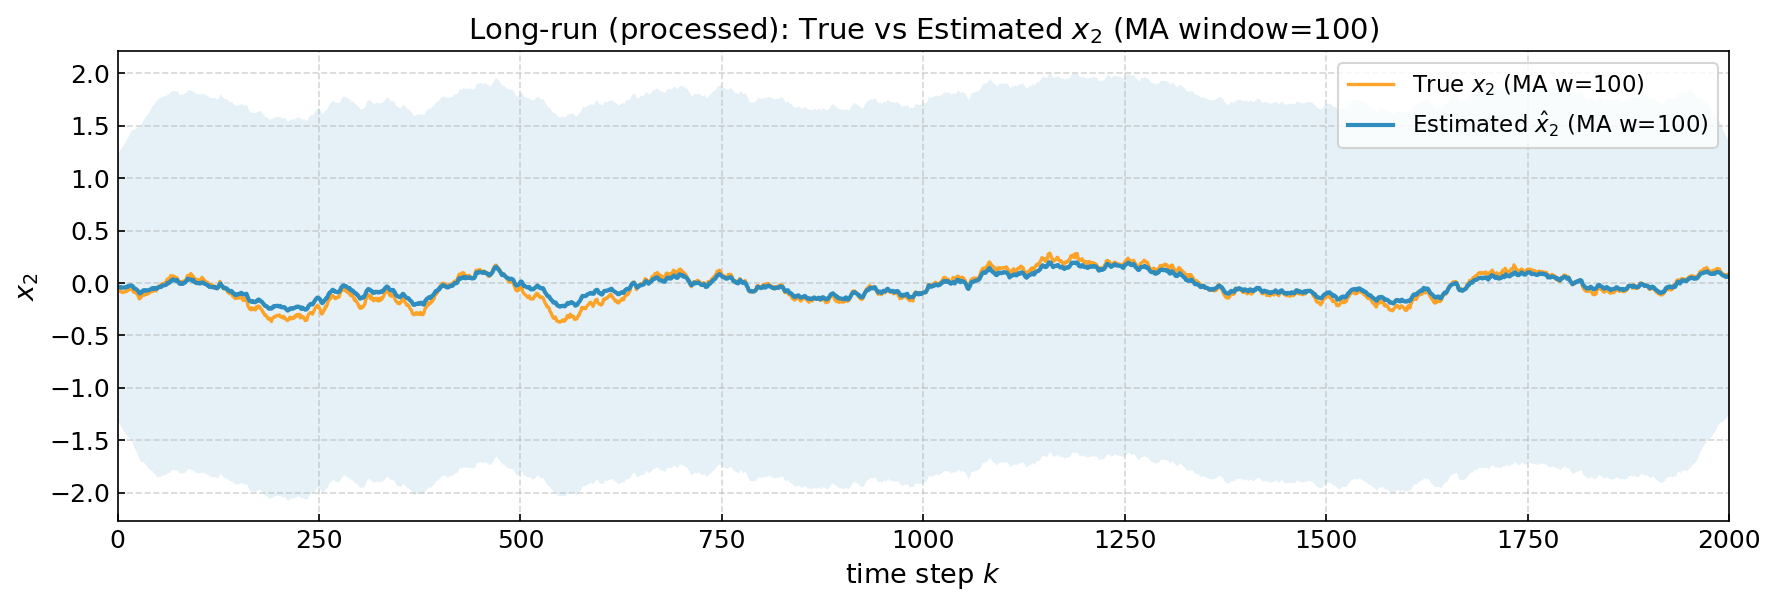

Saved: /mnt/data/long_improved_processed_y_post.png


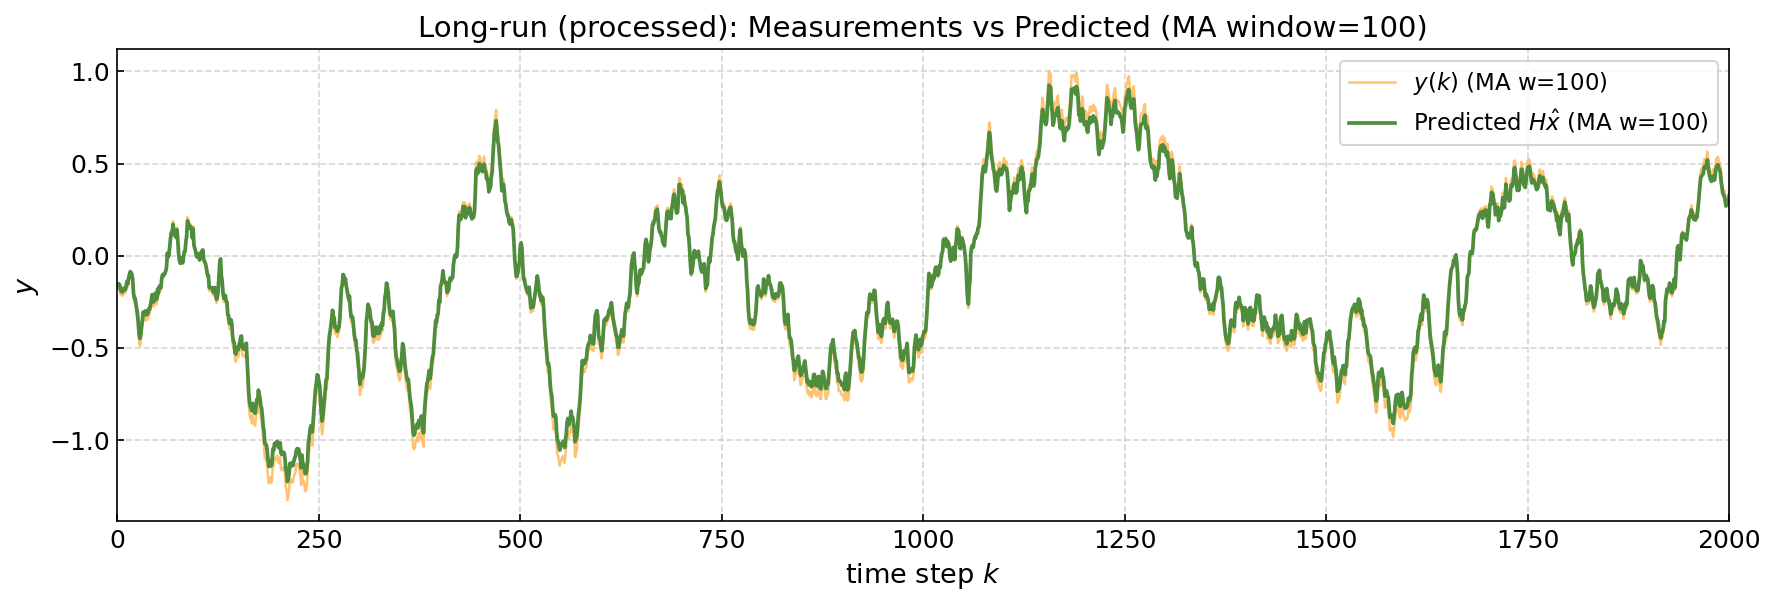

All figures saved to: /mnt/data
Final estimate xhat: [1.40977087 1.05141781]
Final covariance P:
 [[ 0.85251527 -0.72453158]
 [-0.72453158  0.8163006 ]]


In [3]:

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
np.random.seed(7)
N = 2000
ma_window = 100
out_dir = Path('/mnt/data')
out_dir.mkdir(parents=True, exist_ok=True)


#  system
A = np.array([[-1/3, 1.0],
              [ 1/3, 0.0]])
B = np.array([[0.0],
              [1.0]])
H = np.array([[2.0, 2.0]])

Q_w = 1.0
R = 1.0
Qx = B @ (Q_w * np.eye(1)) @ B.T

xhat = np.array([[1.0],
                 [0.0]])
P = np.eye(2)

x_true = np.array([[0.5],
                   [-0.5]])

x_true_hist = np.zeros((2, N+1))
xhat_hist = np.zeros((2, N+1))
Pdiag_hist = np.zeros((2, N+1))
y_hist = np.zeros(N+1)
y_pred_hist = np.zeros(N+1)   # to store the POST-UPDATE predicted measurement H @ xhat(k|k)

# initialize
x_true_hist[:,0] = x_true.flatten()
xhat_hist[:,0] = xhat.flatten()
Pdiag_hist[:,0] = np.diag(P)
y_hist[0] = float((H @ x_true).item() + np.random.randn()*np.sqrt(R))
# initialize stored predicted measurement as H @ xhat(0|0) (posterior at k=0)
y_pred_hist[0] = float((H @ xhat).item())

# the simulate system + Kalman filter
for k in range(N):
    # truth propagation
    w_k = np.random.randn() * np.sqrt(Q_w)
    x_true = A @ x_true + B * w_k

    # measurement (at time k+1)
    v_k = np.random.randn() * np.sqrt(R)
    y_k1 = float((H @ x_true).item() + v_k)

    # predict (a-priori for time k+1)
    xhat_pred = A @ xhat
    P_pred = A @ P @ A.T + Qx

    # compute prior predicted measurement (used for innovation)
    y_prior = float((H @ xhat_pred).item())

    # update (use measurement y_k1 to get posterior at time k+1)
    S = float((H @ P_pred @ H.T).item() + R)
    K = (P_pred @ H.T) / S
    innov = y_k1 - y_prior
    xhat = xhat_pred + K * innov
    P = (np.eye(2) - K @ H) @ P_pred

    # store (time k+1)
    idx = k + 1
    x_true_hist[:, idx] = x_true.flatten()
    xhat_hist[:, idx] = xhat.flatten()
    Pdiag_hist[:, idx] = np.diag(P)
    y_hist[idx] = y_k1
    # store POST-UPDATE predicted measurement H @ xhat(k+1|k+1)
    y_pred_hist[idx] = float((H @ xhat).item())

t = np.arange(N+1)
#used moving avegrage method to smoothen the plots
def moving_average(a, window):
    if window <= 1:
        return a.copy()
    kernel = np.ones(window, dtype=float) / window
    return np.convolve(a, kernel, mode='same')
plt.rcParams.update({
    'figure.dpi': 150,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 13,
    'legend.fontsize': 11,
    'lines.linewidth': 1.6,
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.5
})


color_true = '#ff9f1c'
color_est  = '#2b8cbe'
ci_color   = '#2b8cbe'
meas_color = '#ffbf69'
pred_color = '#4b8b3b'

mark_every = 40


figsize = (12, 4.2)

# x1 raw
fig, ax = plt.subplots(figsize=figsize)
ax.plot(t, x_true_hist[0], label=r'True $x_1$', color=color_true, alpha=0.9, linewidth=1.2)
ax.plot(t, xhat_hist[0], label=r'Estimated $\hat{x}_1$', color=color_est, alpha=0.95, linewidth=1.8)
ax.plot(t[::mark_every], xhat_hist[0, ::mark_every], marker='o', linestyle='', color=color_est, markersize=4, alpha=0.7)
std1 = np.sqrt(Pdiag_hist[0])
ax.fill_between(t, xhat_hist[0]-2*std1, xhat_hist[0]+2*std1, color=ci_color, alpha=0.12, linewidth=0)
ax.set_xlabel('time step $k$'); ax.set_ylabel('$x_1$')
ax.set_title('Long-run (raw): True vs Estimated $x_1$ (±95% CI)')
ax.legend(loc='upper right', frameon=True)
ax.set_xlim(0, N)
ax.tick_params(direction='in')
fig.tight_layout()
f = out_dir / 'long_improved_raw_x1_post.png'
fig.savefig(f, dpi=200)
print("Saved:", f)
plt.show()

# x2 raw
fig, ax = plt.subplots(figsize=figsize)
ax.plot(t, x_true_hist[1], label=r'True $x_2$', color=color_true, alpha=0.9, linewidth=1.2)
ax.plot(t, xhat_hist[1], label=r'Estimated $\hat{x}_2$', color=color_est, alpha=0.95, linewidth=1.8)
ax.plot(t[::mark_every], xhat_hist[1, ::mark_every], marker='s', linestyle='', color=color_est, markersize=4, alpha=0.7)
std2 = np.sqrt(Pdiag_hist[1])
ax.fill_between(t, xhat_hist[1]-2*std2, xhat_hist[1]+2*std2, color=ci_color, alpha=0.12, linewidth=0)
ax.set_xlabel('time step $k$'); ax.set_ylabel('$x_2$')
ax.set_title('Long-run (raw): True vs Estimated $x_2$ (±95% CI)')
ax.legend(loc='upper right', frameon=True)
ax.set_xlim(0, N)
ax.tick_params(direction='in')
fig.tight_layout()
f = out_dir / 'long_improved_raw_x2_post.png'
fig.savefig(f, dpi=200)
print("Saved:", f)
plt.show()

# measurements raw (post-update)
fig, ax = plt.subplots(figsize=figsize)
ax.plot(t, y_hist, label=r'Measurement $y(k)$', color=meas_color, alpha=0.9, linewidth=1.0)
ax.plot(t, y_pred_hist, label=r'Predicted $H\hat{x}$ (post-update)', color=pred_color, alpha=0.95, linewidth=1.6)
ax.plot(t[::mark_every], y_pred_hist[::mark_every], marker='d', linestyle='', color=pred_color, markersize=3, alpha=0.75)
ax.set_xlabel('time step $k$'); ax.set_ylabel('$y$')
ax.set_title('Long-run (raw): Measurements vs Predicted Measurements (post-update aligned)')
ax.legend(loc='upper right', frameon=True)
ax.set_xlim(0, N)
ax.tick_params(direction='in')
fig.tight_layout()
f = out_dir / 'long_improved_raw_y_post.png'
fig.savefig(f, dpi=200)
print("Saved:", f)
plt.show()


# computeign moving averages
x_true_x1_ma = moving_average(x_true_hist[0], ma_window)
xhat_x1_ma = moving_average(xhat_hist[0], ma_window)
Pdiag_x1_ma = moving_average(Pdiag_hist[0], ma_window)

x_true_x2_ma = moving_average(x_true_hist[1], ma_window)
xhat_x2_ma = moving_average(xhat_hist[1], ma_window)
Pdiag_x2_ma = moving_average(Pdiag_hist[1], ma_window)

y_ma = moving_average(y_hist, ma_window)
y_pred_ma = moving_average(y_pred_hist, ma_window)

# x1 processed
fig, ax = plt.subplots(figsize=figsize)
ax.plot(t, x_true_x1_ma, label=fr'True $x_1$ (MA w={ma_window})', color=color_true, alpha=0.95, linewidth=1.6)
ax.plot(t, xhat_x1_ma, label=fr'Estimated $\hat{{x}}_1$ (MA w={ma_window})', color=color_est, alpha=0.98, linewidth=2.0)
std1_ma = np.sqrt(np.maximum(Pdiag_x1_ma, 0))
ax.fill_between(t, xhat_x1_ma-2*std1_ma, xhat_x1_ma+2*std1_ma, color=ci_color, alpha=0.12, linewidth=0)
ax.set_xlabel('time step $k$'); ax.set_ylabel('$x_1$')
ax.set_title(f'Long-run (processed): True vs Estimated $x_1$ (MA window={ma_window})')
ax.legend(loc='upper right', frameon=True)
ax.set_xlim(0, N)
ax.tick_params(direction='in')
fig.tight_layout()
f = out_dir / 'long_improved_processed_x1_post.png'
fig.savefig(f, dpi=200)
print("Saved:", f)
plt.show()

# x2 processed
fig, ax = plt.subplots(figsize=figsize)
ax.plot(t, x_true_x2_ma, label=fr'True $x_2$ (MA w={ma_window})', color=color_true, alpha=0.95, linewidth=1.6)
ax.plot(t, xhat_x2_ma, label=fr'Estimated $\hat{{x}}_2$ (MA w={ma_window})', color=color_est, alpha=0.98, linewidth=2.0)
std2_ma = np.sqrt(np.maximum(Pdiag_x2_ma, 0))
ax.fill_between(t, xhat_x2_ma-2*std2_ma, xhat_x2_ma+2*std2_ma, color=ci_color, alpha=0.12, linewidth=0)
ax.set_xlabel('time step $k$'); ax.set_ylabel('$x_2$')
ax.set_title(f'Long-run (processed): True vs Estimated $x_2$ (MA window={ma_window})')
ax.legend(loc='upper right', frameon=True)
ax.set_xlim(0, N)
ax.tick_params(direction='in')
fig.tight_layout()
f = out_dir / 'long_improved_processed_x2_post.png'
fig.savefig(f, dpi=200)
print("Saved:", f)
plt.show()

# measurements processed
fig, ax = plt.subplots(figsize=figsize)
ax.plot(t, y_ma, label=fr'$y(k)$ (MA w={ma_window})', color=meas_color, alpha=0.95, linewidth=1.2)
ax.plot(t, y_pred_ma, label=fr'Predicted $H\hat{{x}}$ (MA w={ma_window})', color=pred_color, alpha=0.98, linewidth=1.8)
ax.set_xlabel('time step $k$'); ax.set_ylabel('$y$')
ax.set_title(f'Long-run (processed): Measurements vs Predicted (MA window={ma_window})')
ax.legend(loc='upper right', frameon=True)
ax.set_xlim(0, N)
ax.tick_params(direction='in')
fig.tight_layout()
f = out_dir / 'long_improved_processed_y_post.png'
fig.savefig(f, dpi=200)
print("Saved:", f)
plt.show()
#summary
print("All figures saved to:", out_dir)
print("Final estimate xhat:", xhat.flatten())
print("Final covariance P:\n", P)
